# Bike Sharing 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics
import statsmodels.api as sm

from datetime import datetime
from collections import Counter
from scipy import stats as sp
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import chi2
from numpy.polynomial.polynomial import polyfit


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Import data

In [2]:
station_df = pd.read_csv('data/station.csv')
trip_df = pd.read_csv('data/trip.csv')
weather_df = pd.read_csv('data/weather.csv')

### Process Data


In [3]:
#Convert to datetime so that it can be manipulated more easily
trip_df.start_date = pd.to_datetime(trip_df.start_date, format='%m/%d/%Y %H:%M')
trip_df.end_date = pd.to_datetime(trip_df.end_date, format='%m/%d/%Y %H:%M')

#duration is time of trip in seconds; convert to minutes
trip_df.duration = trip_df.duration / 60
trip_df.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

### Examine station data

In [4]:
station_df.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [5]:
station_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
id                   70 non-null int64
name                 70 non-null object
lat                  70 non-null float64
long                 70 non-null float64
dock_count           70 non-null int64
city                 70 non-null object
installation_date    70 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 3.9+ KB


In [6]:
#look for missing data; should be zero as info summary above gives 70 entries for each column
station_df.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [7]:
station_df.city.value_counts()

San Francisco    35
San Jose         16
Redwood City      7
Mountain View     7
Palo Alto         5
Name: city, dtype: int64

Text(0, 0.5, 'number of stations')

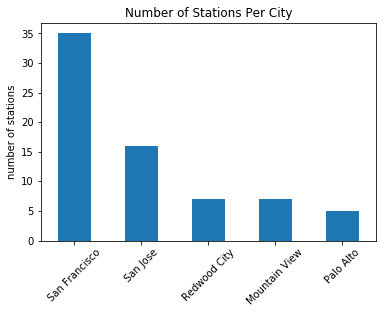

In [8]:
#stations by city
station_df.city.value_counts().plot(kind='bar')
plt.title('Number of Stations Per City')
plt.xticks(rotation=45)
plt.ylabel('number of stations')
# SF has 35 stations

In [9]:
station_df.groupby('city')['dock_count'].sum()

city
Mountain View    117
Palo Alto         75
Redwood City     115
San Francisco    665
San Jose         264
Name: dock_count, dtype: int64

Text(0, 0.5, 'number of docks')

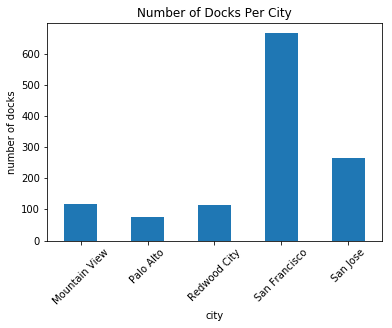

In [10]:
# number of docks per city   
station_df.groupby('city')['dock_count'].sum().plot(kind='bar')
plt.title('Number of Docks Per City')
plt.xticks(rotation=45)
plt.ylabel('number of docks')

# SF has 665

### Narrow focus to SF

In [11]:
# Narrow focus to SF stations
sf_stations = station_df.loc[station_df.city == 'San Francisco']
sf_stations.head()

,id,name,lat,long,dock_count,city,installation_date
32,41,Clay at Battery,37.795001,-122.399970,15,San Francisco,8/19/2013
33,42,Davis at Jackson,37.797280,-122.398436,15,San Francisco,8/19/2013
34,45,Commercial at Montgomery,37.794231,-122.402923,15,San Francisco,8/19/2013
35,46,Washington at Kearney,37.795425,-122.404767,15,San Francisco,8/19/2013
36,47,Post at Kearney,37.788975,-122.403452,19,San Francisco,8/19/2013


In [12]:
# Narrow focus to SF trips
sf_id = list(sf_stations.id)
sf_trips = trip_df[trip_df.start_station_id.isin(sf_id)]
sf_trips.start_station_id.unique()

array([66, 59, 49, 64, 41, 47, 67, 74, 39, 58, 56, 55, 61, 72, 45, 76, 62,
       46, 68, 71, 69, 73, 48, 75, 70, 50, 77, 65, 60, 42, 54, 57, 51, 63,
       82])

### Examine SF trip data

In [13]:
sf_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103
10,4549,2.083333,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109


In [14]:
sf_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 603708 entries, 0 to 669958
Data columns (total 11 columns):
id                    603708 non-null int64
duration              603708 non-null float64
start_date            603708 non-null datetime64[ns]
start_station_name    603708 non-null object
start_station_id      603708 non-null int64
end_date              603708 non-null datetime64[ns]
end_station_name      603708 non-null object
end_station_id        603708 non-null int64
bike_id               603708 non-null int64
subscription_type     603708 non-null object
zip_code              597599 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 55.3+ MB


In [15]:
# Create column denoting weekend or weekday: DOW

sf_trips['weekday'] = pd.DatetimeIndex(sf_trips.start_date).dayofweek

sf_trips['DOW'] = None
sf_trips['DOW'] = ['weekend' if day in [5,6] else "weekday" for day in sf_trips['weekday']]
sf_trips = sf_trips.copy()

In [16]:
sf_trips.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,weekday,DOW
0,4576,1.050000,2013-08-29 14:13:00,South Van Ness at Market,66,2013-08-29 14:14:00,South Van Ness at Market,66,520,Subscriber,94127,3,weekday
4,4299,1.383333,2013-08-29 12:02:00,South Van Ness at Market,66,2013-08-29 12:04:00,Market at 10th,67,319,Subscriber,94103,3,weekday
5,4927,1.716667,2013-08-29 18:54:00,Golden Gate at Polk,59,2013-08-29 18:56:00,Golden Gate at Polk,59,527,Subscriber,94109,3,weekday
8,4760,1.883333,2013-08-29 17:01:00,South Van Ness at Market,66,2013-08-29 17:03:00,South Van Ness at Market,66,553,Subscriber,94103,3,weekday
10,4549,2.083333,2013-08-29 13:52:00,Spear at Folsom,49,2013-08-29 13:55:00,Embarcadero at Bryant,54,368,Subscriber,94109,3,weekday


In [17]:
sf_trips.duration.describe()         

count    603708.000000
mean         17.117811
std         380.557814
min           1.000000
25%           5.916667
50%           8.750000
75%          12.600000
max      287840.000000
Name: duration, dtype: float64

The mean duration of 17.117811 is greater than 75% of the data, and the std is 380.557814 (over 6 hours). The max duration is 4797 hours. Clearly, outliers are strongly affecting the data. Rather than replacing the values with the median value for duration, these trips will not included in the clean dataset as these trips are most likely errors in usage.

#### Remove Outliers

Since the std is so large and the 3Q is 12.6, using 3SD to remove outliers will not be effective. Instead, we used quantiles to identify extreme values.

In [18]:
# quartile_1, quartile_3 = np.percentile(sf_trips['duration'], [25, 75])
# iqr = quartile_3 - quartile_1
# lower_bound = quartile_1 - (float(iqr) * 1.5)
# upper_bound = quartile_3 + (float(iqr) * 1.5)

# sf_trips_clean2 = sf_trips.loc[sf_trips.duration < upper_bound]

## This results in a lower bound is a negative number (negative ride duration) and an upper bound of 22.6249995.
## This removes a significant amount of valid trips from the data. The method below retains 98% of the data and
## retaining trips with a resonable range of durations for us to explore.

In [19]:
# large std of 380.557814 and 3Q = 12.6; use quantiles instead of 3SD

np.quantile(sf_trips.duration, .98)  #102.64766666666645

102.64766666666645

In [20]:
sf_trips_clean = sf_trips.loc[sf_trips.duration < np.quantile(sf_trips.duration, 0.98)]


#### Compare before and after removal of outliers: sf_trips vs sf_trips_clean

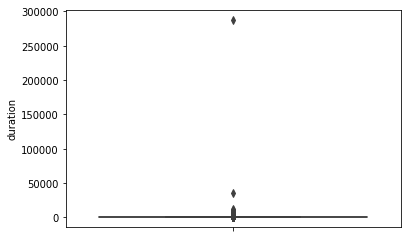

In [21]:
sb.boxplot(sf_trips['duration'], orient='v')

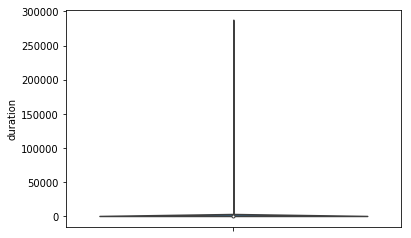

In [22]:
sb.violinplot(sf_trips['duration'], orient='v', showfliers=False)

In [23]:
sf_trips.duration.describe()  #with outliers

count    603708.000000
mean         17.117811
std         380.557814
min           1.000000
25%           5.916667
50%           8.750000
75%          12.600000
max      287840.000000
Name: duration, dtype: float64

In [24]:
sf_trips_clean.duration.describe() #without outliers

count    591633.000000
mean         10.652207
std           9.414143
min           1.000000
25%           5.866667
50%           8.616667
75%          12.300000
max         102.633333
Name: duration, dtype: float64

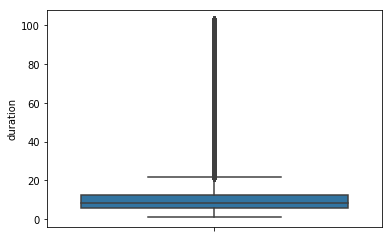

In [25]:
sb.boxplot(sf_trips_clean['duration'], orient='v')

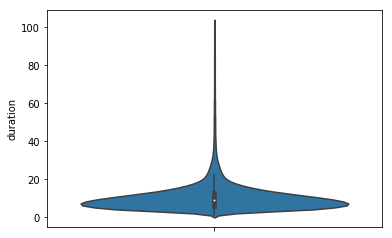

In [26]:
sb.violinplot(sf_trips_clean['duration'], orient='v', showfliers=False)

In [27]:
sf_trips_clean.duration.describe()

count    591633.000000
mean         10.652207
std           9.414143
min           1.000000
25%           5.866667
50%           8.616667
75%          12.300000
max         102.633333
Name: duration, dtype: float64

The mean is now 10.652207 and the std is 9.414143. After the removal of the outliers, we can see from the violin plot the density of the data around the mean.

#### Comparisons: Subscriber vs. Customer, Weekday vs. Weekend

We divide data by subscription type and by day of week to examine possible differences in ride usage. These categories may provide insight into patterns of commuters or causual rides.

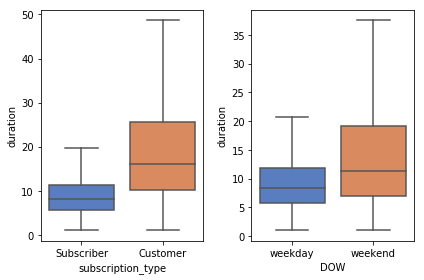

In [28]:
plt.subplot(1, 2, 1)
sb.boxplot(x='subscription_type', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

plt.subplot(1, 2, 2)
sb.boxplot(x='DOW', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)
plt.tight_layout()

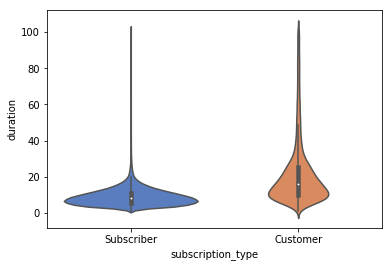

In [29]:
sb.violinplot(x='subscription_type', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

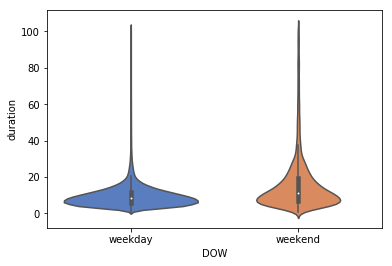

In [30]:
sb.violinplot(x='DOW', y='duration', data=sf_trips_clean, palette="muted", showfliers=False)

Most subscriber trips have a duration less than 20 minutes while the customer trips have a larger range and tend to a longer duration. Similar patterns can be seen in comparing the weekday versus weekend durations. It may be that weekday trips tend to be commuters (and thus subscribers) whereas weekend trips (and one off customers) would be sightseeing and more leisurely rides.

In [31]:
# Compare counts of trips per hour weekday vs weekend
# As most trips are weekday trips, we examine proportional numbers

In [32]:
weekday_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.DOW == 'weekday'].start_date).hour
weekend_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.DOW == 'weekend'].start_date).hour

In [33]:
weekday_counts = Counter(weekday_counts)
weekend_counts = Counter(weekend_counts)

In [34]:
weekday_props = {hour:weekday_counts[hour]/sum(weekday_counts.values()) for hour in weekday_counts}
weekend_props = {hour:weekend_counts[hour]/sum(weekend_counts.values()) for hour in weekend_counts}

In [35]:
xd = range(0,24)
yd = [weekday_props[hour] for hour in range(0,24)]

xe = range(0,24)
ye = [weekend_props[hour] for hour in range(0,24)]

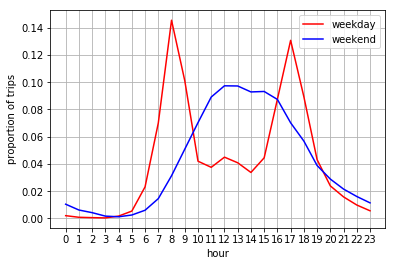

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.plot(xd, yd, 'r-', xe, ye, 'b-')
plt.xticks(xe)

ax.set_xlabel('hour')
ax.set_ylabel('proportion of trips') #at start time
ax.legend(['weekday', 'weekend'])
ax.grid()


The clear spikes at morning and evening commute times and a lesser spike at lunchtime support our observations that weekday usage is tied to commuting. Weekend usage, on the other hand, has a gentle curve peaking midday and gradually decreasing through the afternoon as one would expect from more leisurely rides and sightseeing.

In [37]:
cust_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.subscription_type == 'subscriber'].start_date).hour
sub_counts = pd.DatetimeIndex(sf_trips.loc[sf_trips.subscription_type == 'customer'].start_date).hour

In [38]:
cust_counts = Counter(cust_counts)
sub_counts = Counter(sub_counts)

In [39]:
#weekday_props = {hour:weekday_counts[hour]/sum(weekday_counts.values()) for hour in weekday_counts}
#weekend_props = {hour:weekend_counts[hour]/sum(weekend_counts.values()) for hour in weekend_counts}

### Examine weather data

In [40]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,8/29/2013,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,8/30/2013,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,8/31/2013,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,9/1/2013,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,9/2/2013,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107


In [41]:
weather_df.shape

(3665, 24)

In [42]:
weather_df.date = pd.to_datetime(weather_df.date, format='%m/%d/%Y')
weather_df = weather_df.sort_values('date')

weather_df.head(10)

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
552,2013-08-29,80.0,70.0,64.0,65.0,61.0,58.0,83.0,72.0,55.0,...,10.0,10.0,16.0,5.0,16.0,0,4.0,NaN,355.0,94041
368,2013-08-29,78.0,71.0,64.0,62.0,61.0,60.0,87.0,71.0,54.0,...,10.0,10.0,20.0,8.0,23.0,0,4.0,NaN,355.0,94301
184,2013-08-29,80.0,71.0,62.0,63.0,59.0,57.0,94.0,79.0,48.0,...,10.0,10.0,14.0,6.0,17.0,0,5.0,NaN,313.0,94063
736,2013-08-29,81.0,72.0,63.0,62.0,61.0,59.0,87.0,69.0,51.0,...,10.0,10.0,16.0,7.0,24.0,0,4.0,NaN,320.0,95113
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
369,2013-08-30,84.0,74.0,64.0,63.0,61.0,57.0,93.0,68.0,43.0,...,10.0,10.0,20.0,6.0,23.0,0,2.0,NaN,5.0,94301
185,2013-08-30,86.0,74.0,62.0,64.0,59.0,54.0,94.0,73.0,35.0,...,10.0,10.0,15.0,2.0,17.0,0,2.0,NaN,292.0,94063
553,2013-08-30,87.0,72.0,63.0,66.0,61.0,57.0,84.0,68.0,47.0,...,10.0,10.0,15.0,2.0,18.0,0,2.0,NaN,5.0,94041
737,2013-08-30,88.0,76.0,63.0,63.0,60.0,55.0,93.0,65.0,37.0,...,10.0,10.0,18.0,5.0,22.0,0,2.0,NaN,316.0,95113


In [43]:
weather_df.zip_code.unique()

array([94107, 94041, 94301, 94063, 95113])

As we are only analyzing San Francisco data, we will only need data associated with the zip code 94107. The other zip codes represent weather data for the other cities in the data collected.

In [44]:
weather_df = weather_df[weather_df.zip_code==94107]
weather_df.head(10)

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107
5,2013-09-03,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,...,10.0,10.0,24.0,15.0,31.0,0,2.0,NaN,276.0,94107
6,2013-09-04,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,...,10.0,10.0,29.0,19.0,35.0,0,4.0,NaN,269.0,94107
7,2013-09-05,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,...,10.0,10.0,31.0,21.0,37.0,0,3.0,NaN,270.0,94107
8,2013-09-06,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,...,10.0,10.0,24.0,8.0,28.0,0,0.0,NaN,287.0,94107
9,2013-09-07,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,...,10.0,10.0,21.0,8.0,25.0,0,1.0,NaN,305.0,94107


In [45]:
weather_df['precipitation_inches'].unique()  
#there is a 'T'; not all values are numberic

array(['0', '0.23', 'T', '0.01', '0.28', '0.63', '0.29', '0.06', '0.85',
       '0.09', '0.64', '0.42', '0.35', '0.43', '0.22', '0.74', '0.03',
       '0.02', '0.1', '0.26', '0.15', '0.87', '0.57', '0.69', '0.32',
       '0.11', '0.2', '0.66', '0.08', '1.18', '1.43', '3.12', '0.48',
       '0.19', '1.09', '0.65', '0.13', '0.25', '0.91', '0.99', '0.07',
       '0.05', '0.52', '0.14', '0.18'], dtype=object)

In [46]:
# Replace non numeric with mean values
weather_df.precipitation_inches = np.where(weather_df.precipitation_inches == 'T', np.nan, weather_df.precipitation_inches)
weather_df.precipitation_inches = weather_df.precipitation_inches.astype(float)
weather_df.precipitation_inches = weather_df.precipitation_inches.fillna(np.nanmean(weather_df.precipitation_inches))

In [47]:
weather_df['precipitation_inches'].unique()  

array([0.        , 0.23      , 0.03705882, 0.01      , 0.28      ,
       0.63      , 0.29      , 0.06      , 0.85      , 0.09      ,
       0.64      , 0.42      , 0.35      , 0.43      , 0.22      ,
       0.74      , 0.03      , 0.02      , 0.1       , 0.26      ,
       0.15      , 0.87      , 0.57      , 0.69      , 0.32      ,
       0.11      , 0.2       , 0.66      , 0.08      , 1.18      ,
       1.43      , 3.12      , 0.48      , 0.19      , 1.09      ,
       0.65      , 0.13      , 0.25      , 0.91      , 0.99      ,
       0.07      , 0.05      , 0.52      , 0.14      , 0.18      ])

In [48]:
weather_df.isnull().sum()

date                                0
max_temperature_f                   0
mean_temperature_f                  0
min_temperature_f                   0
max_dew_point_f                     0
mean_dew_point_f                    0
min_dew_point_f                     0
max_humidity                        0
mean_humidity                       0
min_humidity                        0
max_sea_level_pressure_inches       0
mean_sea_level_pressure_inches      0
min_sea_level_pressure_inches       0
max_visibility_miles                0
mean_visibility_miles               0
min_visibility_miles                0
max_wind_Speed_mph                  0
mean_wind_speed_mph                 0
max_gust_speed_mph                 13
precipitation_inches                0
cloud_cover                         0
events                            574
wind_dir_degrees                    0
zip_code                            0
dtype: int64

In [49]:
weather_df.events.unique()     

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'],
      dtype=object)

In [50]:
weather_df.events = np.where((weather_df.events == 'rain') | (weather_df.events == 'Rain-Thunderstorm'), 'Rain', weather_df.events)
weather_df.events.fillna('Normal', inplace = True)
weather_df.events.unique()

array(['Normal', 'Fog', 'Rain', 'Fog-Rain'], dtype=object)

In [51]:
events = pd.get_dummies(weather_df.events)
weather_df = weather_df.merge(events, left_index = True, right_index = True)

In [52]:
weather_df.head()

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code,Fog,Fog-Rain,Normal,Rain
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,28.0,0.0,4.0,Normal,286.0,94107,0,0,1,0
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,35.0,0.0,2.0,Normal,291.0,94107,0,0,1,0
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,31.0,0.0,4.0,Normal,284.0,94107,0,0,1,0
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,29.0,0.0,4.0,Normal,284.0,94107,0,0,1,0
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,30.0,0.0,6.0,Normal,277.0,94107,0,0,1,0


In [53]:
weather_df = weather_df.drop(columns=['max_dew_point_f', 'min_dew_point_f', 'max_sea_level_pressure_inches', 
                                      'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches', 
                                      'max_gust_speed_mph', 'events','zip_code'])

### How does weather affect bike usage?

Does weather have a strong effect on bike usage? We examine how temperature and precipitation affect bike usage, specifically duration of trips.

### Trips per day

In [54]:
# Extract the year, month, and day from start_date
sf_trips_clean['date'] = sf_trips_clean.start_date.dt.date

# Finding total number of times a date is listed: trips_per_date_df
daily_trips = {}
for d in sf_trips_clean.date:
    if d not in daily_trips:
        daily_trips[d] = 1
    else:
        daily_trips[d] += 1

daily_trips_df = pd.DataFrame.from_dict(daily_trips, orient = "index", columns=['trips'])

daily_trips_df['date'] = daily_trips_df.index 
daily_trips_df = daily_trips_df.sort_values('date')
daily_trips_df.reset_index(drop=True, inplace=True)

daily_trips_df.head()

,trips,date
0,631,2013-08-29
1,556,2013-08-30
2,485,2013-08-31
3,538,2013-09-01
4,532,2013-09-02


In [55]:
daily_trips_df = daily_trips_df.sort_values('date')

# Add column for weekday (True) vs weekend (False)
daily_trips_df['weekday'] = pd.DatetimeIndex(daily_trips_df.date).dayofweek
daily_trips_df['weekday'] = [False if day in [5,6] else True for day in daily_trips_df['weekday']]


#Convert True to 1 and False to 0
daily_trips_df['weekday'] = daily_trips_df.weekday.map(lambda x: 1 if x == True else 0)

daily_trips_df.tail()


,trips,date,weekday
728,1314,2015-08-27,1
729,1097,2015-08-28,1
730,283,2015-08-29,0
731,244,2015-08-30,0
732,1228,2015-08-31,1


In [56]:
daily_trips_df = daily_trips_df.merge(weather_df, on = daily_trips_df.date)

In [57]:
daily_trips_df.head()

,key_0,trips,date_x,weekday,date_y,max_temperature_f,mean_temperature_f,min_temperature_f,mean_dew_point_f,max_humidity,...,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,precipitation_inches,cloud_cover,wind_dir_degrees,Fog,Fog-Rain,Normal,Rain
0,2013-08-29,631,2013-08-29,1,2013-08-29,74.0,68.0,61.0,58.0,93.0,...,10.0,23.0,11.0,0.0,4.0,286.0,0,0,1,0
1,2013-08-30,556,2013-08-30,1,2013-08-30,78.0,69.0,60.0,58.0,90.0,...,7.0,29.0,13.0,0.0,2.0,291.0,0,0,1,0
2,2013-08-31,485,2013-08-31,0,2013-08-31,71.0,64.0,57.0,56.0,93.0,...,10.0,26.0,15.0,0.0,4.0,284.0,0,0,1,0
3,2013-09-01,538,2013-09-01,0,2013-09-01,74.0,66.0,58.0,56.0,87.0,...,10.0,25.0,13.0,0.0,4.0,284.0,0,0,1,0
4,2013-09-02,532,2013-09-02,1,2013-09-02,75.0,69.0,62.0,60.0,93.0,...,6.0,23.0,12.0,0.0,6.0,277.0,0,0,1,0


In [58]:
daily_trips_df.rename(columns={'key_0':'date'}, inplace=True)
daily_trips_df.drop(columns=['date_x','date_y'], axis=1, inplace= True)
daily_trips_df.reset_index(drop=True, inplace=True)

In [59]:
daily_trips_df.columns

Index(['date', 'trips', 'weekday', 'max_temperature_f', 'mean_temperature_f',
       'min_temperature_f', 'mean_dew_point_f', 'max_humidity',
       'mean_humidity', 'min_humidity', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'precipitation_inches', 'cloud_cover',
       'wind_dir_degrees', 'Fog', 'Fog-Rain', 'Normal', 'Rain'],
      dtype='object')

### Explore trips vs weather

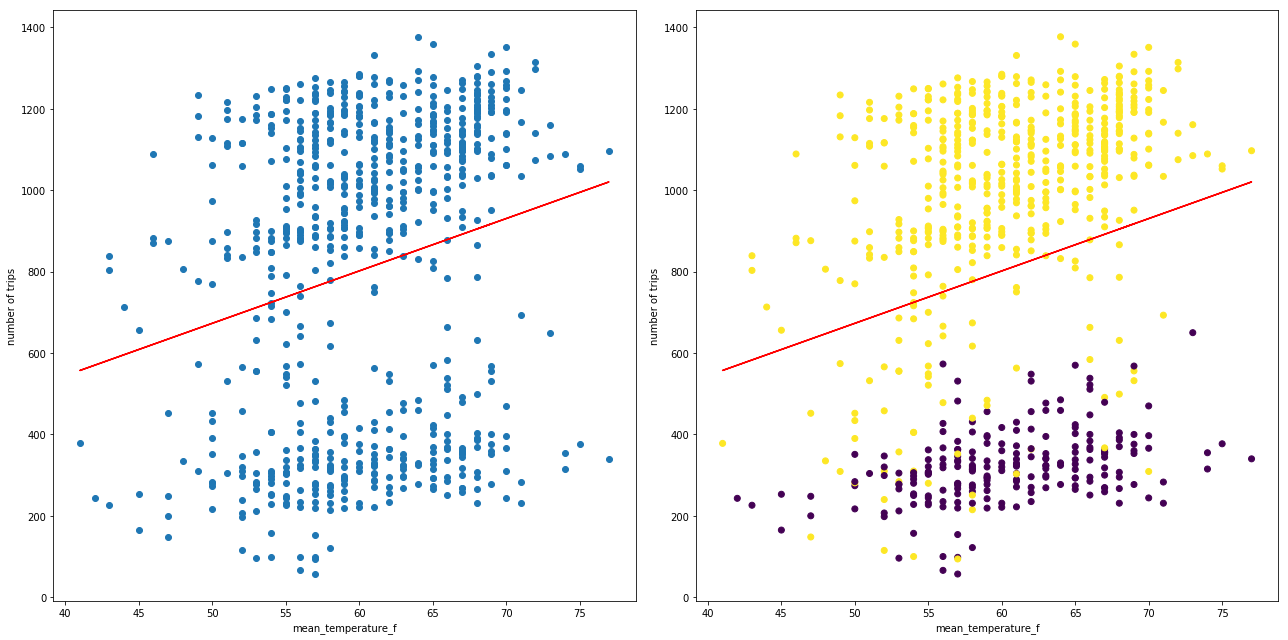

In [60]:

# Fit with polyfit
b, m = polyfit(daily_trips_df.mean_temperature_f, daily_trips_df.trips, 1)
plt.figure(figsize=(18,9))

plt.subplot(121)

plt.scatter(daily_trips_df.mean_temperature_f, daily_trips_df.trips)
plt.plot(daily_trips_df.mean_temperature_f, b + m * daily_trips_df.mean_temperature_f, '-', color='red')
plt.xlabel('mean_temperature_f')
plt.ylabel('number of trips')

# after viewing the distinct clusters added weekday dimension to see if clusters were due to day of week
plt.subplot(122)
plt.scatter(daily_trips_df.mean_temperature_f, daily_trips_df.trips, c=daily_trips_df.weekday)
plt.plot(daily_trips_df.mean_temperature_f, b + m * daily_trips_df.mean_temperature_f, '-', color='red')
plt.xlabel('mean_temperature_f')
plt.ylabel('number of trips')

plt.tight_layout()

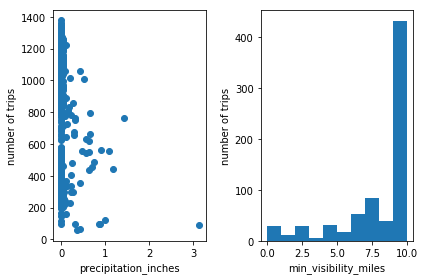

In [61]:
plt.subplot(121)
plt.scatter(daily_trips_df.precipitation_inches, daily_trips_df.trips)

plt.xlabel('precipitation_inches')
plt.ylabel('number of trips')


plt.subplot(122)
# #plt.scatter(daily_trips_df.min_visibility_miles, daily_trips_df.trips)
plt.hist(daily_trips_df.min_visibility_miles)

plt.xlabel('min_visibility_miles')
plt.ylabel('number of trips')

plt.tight_layout()

### Bootstrap Hypothesis Testing

In [62]:
np.random.seed(48)
N_rep = 10000

def draw_bs_reps(data, func, size=1):
    # initialize array
    bs_replicates = np.empty(size)
    
    # generate replicates
    for i in range(size):
        sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(sample)
        
    return bs_replicates


In [63]:
# subset into arrays: subscriber and customer
subscriber = np.array(sf_trips_clean[sf_trips_clean.subscription_type=='Subscriber'].duration)
customer = np.array(sf_trips_clean[sf_trips_clean.subscription_type=='Customer'].duration)

In [64]:
# difference in observed mean for subscriber and customer
obs_diff_mean = np.mean(subscriber) - np.mean(customer)

# : Calculate the 95% confidence interval for the difference between the means
sub_mean_replicates = draw_bs_reps(subscriber, np.mean, size=10000)
cust_mean_replicates = draw_bs_reps(customer, np.mean, size=10000)

bs_diff_mean = draw_bs_reps(subscriber, np.mean, size=10000) - draw_bs_reps(customer, np.mean, size=10000)

ci_bs_mean = np.percentile(bs_diff_mean, [2.5, 97.5])

print("The 95% confidence interval for the difference between replicant subscribers and customers is: ", ci_bs_mean)

The 95% confidence interval for the difference between replicant subscribers and customers is:  [-13.01267123 -12.75428161]


#### Bootstrap Procedure Using Mean As Test Statistic

In [65]:
# Bootstrap Procedure Using Mean As Test Statistic

# Merge the two observed samples into one sample of (n + m) observations
# Draw a bootstrap sample of (n + m) observations with replacement from the merged sample.
reps = 10000

# Concatenate the data sets: data
data = np.concatenate((subscriber, customer))
sub_bs_rep_means = np.empty(reps)
cust_bs_rep_means = np.empty(reps)
        
# generate replicates
for i in range(reps):

    # Sample with replacement the concatenated array: sampled_data
    sampled_data = np.random.choice(data, len(data))

    # Split the sampled array into two: sample_1, sample_2
    sub_sample = sampled_data[:len(subscriber)]
    cust_sample = sampled_data[len(subscriber):]

    # Calculate means
    sub_bs_rep_means[i] = np.mean(sub_sample)
    cust_bs_rep_means[i] = np.mean(cust_sample)
    
# Calculate difference in means: diff_bs_rep_means
diff_bs_rep_means = sub_bs_rep_means - cust_bs_rep_means

# Compute p-value: p
p = np.sum(diff_bs_rep_means >= obs_diff_mean) / len(diff_bs_rep_means)

# Print the result
print('p-value =', p)


p-value = 1.0



For $\alpha$ = 0.05,

$H_0$ : There is no difference in trip duration between subscribers and customers.


$H_a$ : There is a difference in trip duration between subscribers and customers.

p = 1.0

We do not reject the null hypothesis. There is no statistical difference between subscribers and customers.



#### Bootstrap Procedure Using Standard Deviation As Test Statistic

In [66]:
# Bootstrap Procedure Using Standard Deviation As Test Statistic

# Merge the two observed samples into one sample of (n + m) observations
# Draw a bootstrap sample of (n + m) observations with replacement from the merged sample.
reps = 10000

# Concatenate the data sets: data
sub_bs_rep_std = np.empty(reps)
cust_bs_rep_std = np.empty(reps)
        

# generate replicates
for i in range(reps):

    # Sample with replacement the concatenated array: sampled_data
    sampled_data = np.random.choice(data, len(data))

    # Split the sampled array into two: sample_1, sample_2
    sub_sample = sampled_data[:len(subscriber)]
    cust_sample = sampled_data[len(subscriber):]

    # Calculate means
    sub_bs_rep_std[i] = np.std(sub_sample)
    cust_bs_rep_std[i] = np.std(cust_sample)
    
# Calculate difference in means: diff_bs_rep_means
diff_bs_rep_std = sub_bs_rep_std - cust_bs_rep_std

# difference in observed mean
obs_diff_std = np.std(subscriber) - np.std(customer)    


# Compute p-value: p
p = np.sum(diff_bs_rep_std >= obs_diff_std) / len(diff_bs_rep_std)

# Print the result
print('p-value =', p)


p-value = 1.0


In [67]:
# Narrowing variables; removing mean_temp etc. to watch for closer 
daily_trips_df = daily_trips_df.drop(columns = ['mean_temperature_f', 'mean_humidity', 'mean_visibility_miles', \
                                                'mean_wind_speed_mph', 'Normal'])

In [68]:
#daily_trips_df2 = daily_trips_df[['weekday', 'max_temperature_f', 'max_humidity', 'precipitation_inches', \
#                                 'cloud_cover', 'Fog-Rain']]

# Does weather affect number of trips per day?

## Create a model using weather data to predict trips per day

### Train Test Split

In [69]:
y = daily_trips_df.trips
X = daily_trips_df.drop(columns = ['trips', 'date'])

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 7)

### Rescaling

In [71]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(549, 15)
(184, 15)


## Creating a predictive model - Linear Regression

In [72]:
# train
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
# predict
y_pred = linreg.predict(X_test)

In [74]:
coef = pd.DataFrame(linreg.coef_, columns=['Co-efficient'])
attribute = pd.DataFrame(X.columns, columns=['Attribute'])
coef_df = pd.concat([attribute, coef], axis=1, join='inner')

scores, pvalues = chi2(X, y)
pvalues = pd.DataFrame(pvalues, columns=['pvalues'])
coef_df = pd.concat([coef_df, pvalues], axis=1, join='inner')
coef_df


,Attribute,Co-efficient,pvalues
0,weekday,676.900292,1.000000e+00
1,max_temperature_f,420.020979,9.992079e-01
2,min_temperature_f,-16.876437,9.993661e-01
3,mean_dew_point_f,91.943932,6.160493e-01
4,max_humidity,125.294426,9.987384e-01
5,min_humidity,-30.049946,5.487181e-170
6,max_visibility_miles,33.442972,1.000000e+00
7,min_visibility_miles,58.915323,9.294101e-03
8,max_wind_Speed_mph,-69.826023,8.321388e-31
9,precipitation_inches,-912.042074,1.119223e-02


In [75]:
print('R^2: ', linreg.score(X_train, y_train))
print('R^2: ', linreg.score(X_test, y_test))
print('Mean squared error:  ', mean_squared_error(y_test, y_pred))
print('Root Mean squared error:  ', np.sqrt(mean_squared_error(y_test, y_pred)))

R^2:  0.7593376616350709
R^2:  0.7777183308707974
Mean squared error:   27829.356232198203
Root Mean squared error:   166.82133026743972


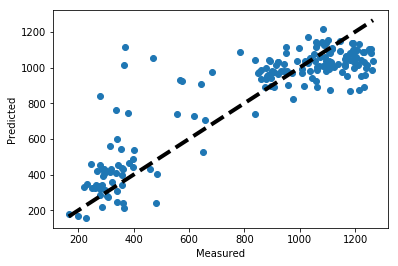

In [76]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()

### Perform 10-fold Cross Validation

In [77]:
# Perform 10-fold CV
cvscores_10 = cross_val_score(linreg, X, y, cv=10)
print(np.mean(cvscores_10))


0.6243559266934536


## Random Forest Regressor

In [78]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train)

# Use the forest's predict method on the test data
y_pred = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))



Mean Absolute Error: 121.46


In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('mean_absolute_percentage_error:  ', mean_absolute_percentage_error(y_test, y_pred))

mean_absolute_percentage_error:   18.025771128780036


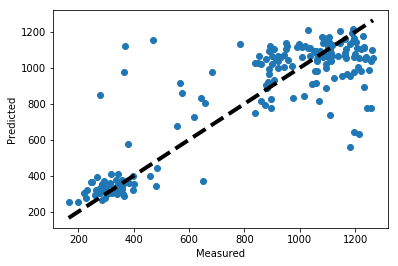

In [80]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.show()
